# Vector Quantization Example

## Original image
- SciPy에서 라쿤 얼굴 이미지를 로딩받는 걸로 시작한다.
- 이미지의 모양이나 데이터와 같은 추가적인 정보를 확인한다.
- SciPy 버전에 따라 이미지를 반환하는 기능이 동일한 모듈에 없기 때문에 `import`를 바꿔야 한다.
- SciPy $\ge$ 1.10에서는 패키지 `pooch`를 설치해야 한다.

In [5]:
try:    # SciPy >= 1.10
    from scipy.datasets import face
except ImportError:
    from scipy.misc import face

raccoon_face = face(gray=True) # gray=True는 회색조 이미지를 가져오도록 지정한다.

print(f"The dimension of the images is  {raccoon_face.shape}")
print(f"The data used to encode the image is of type {raccoon_face.dtype}")
print(f"The number of bytes taken in RAM is {raccoon_face.nbytes}")

The dimension of the images is  (768, 1024)
The data used to encode the image is of type uint8
The number of bytes taken in RAM is 786432


- 이미지 높이: 768px, 이미지 넓이: 1024px인 2차원 배열이다.
- 각 값은 8비트의 부호 없는 정수인데, 이것은 이미지가 픽셀당 8비트으를 사용해 인코딩 된다는 것을 의미한다.
- 이미지의 총 메모리 사용량은 786 킬로바이트이다.

- 8비트의 부호 없는 정수를 사용한다는 것은 영상이 256가지의 다른 회색 음영을 사용하여 부호화된다는 것을 의미한다.

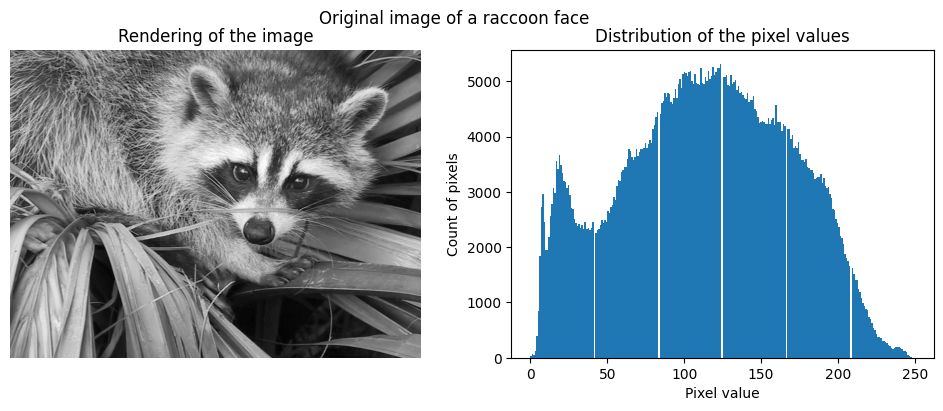

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

ax[0].imshow(raccoon_face, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Rendering of the image')
ax[1].hist(raccoon_face.ravel(), bins=256) # racoon_face.ravel(): 이미지 데이터를 1차원 배열로 펼진다. bins=256: 히스토그램의 막대의 개수를 256개로 설정한다.
ax[1].set_xlabel('Pixel value')
ax[1].set_ylabel('Count of pixels')
ax[1].set_title('Distribution of the pixel values')
_ = fig.suptitle('Original image of a raccoon face')

## Compression via vector quantization
- 벡터 양자화를 통한 압축의 원리는 이미지를 표현하기 위한 그레이 레벨의 수를 줄이는 것이다.
    - 256개의 값을 사용하는 대신 8개의 값을 사용할 수 있다.
- 8비트 대신 3비트를 사용하여 하나의 픽셀을 부호화할 수 있으므로 메모리 사용량을 약 2.5배 줄일 수 있다.

### Encoding strategy
- 압축은 `KBinsDiscreteizer`를 사용하여 수행할 수 있다.
- 하위 표본에 대한 8개의 그레이 값을 정의하는 전략을 선택해야 한다.
- `strategy='uniform'`: 가장 간단한 전략은 동일한 간격으로 정의하는 것이다.

c:\Users\Cal-01\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


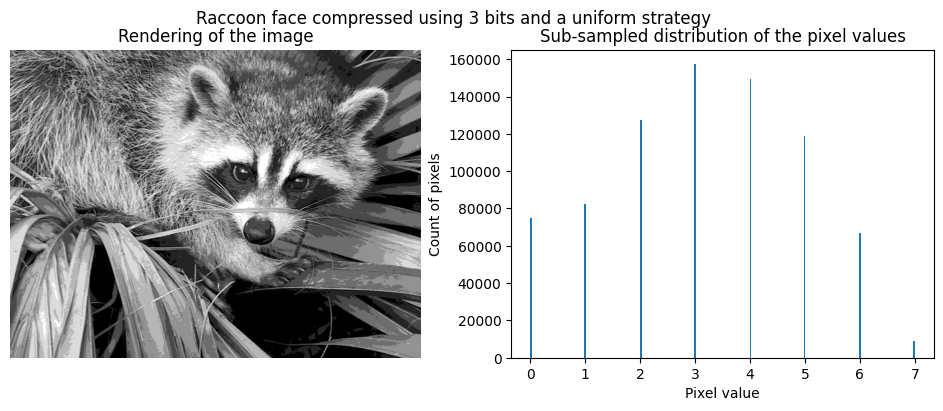

In [8]:
from sklearn.preprocessing import KBinsDiscretizer

n_bins = 8
encoder = KBinsDiscretizer(
    n_bins=n_bins, encode='ordinal', strategy='uniform', random_state=0
)
compressed_raccoon_uniform = encoder.fit_transform(raccoon_face.reshape(-1, 1)).reshape(
    raccoon_face.shape
)

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

ax[0].imshow(compressed_raccoon_uniform, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Rendering of the image')
ax[1].hist(compressed_raccoon_uniform.ravel(), bins=256)    # racoon_face.ravel(): 이미지 데이터를 1차원 배열로 펼진다. bins=256: 히스토그램의 막대의 개수를 256개로 설정한다.
ax[1].set_xlabel('Pixel value')
ax[1].set_ylabel('Count of pixels')
ax[1].set_title('Sub-sampled distribution of the pixel values')
_ = fig.suptitle('Raccoon face compressed using 3 bits and a uniform strategy')

- 질적으로 우리는 압축의 효과를 볼 수 있는 작은 부분을 발견할 수 있습니다.
    - 오른쪽 하단 모서리의 나뭇잎
- 여전히 이미지는 좋아 보인다.
- 픽셀 값의 분포가 8개의 다른 값에 매핑된다.
    - 이런 값들과 원래 픽셀 값 사이의 대응을 확인할 수 있다.

In [9]:
bin_edges = encoder.bin_edges_[0]
bin_center = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1]) / 2
bin_center

array([ 15.625,  46.875,  78.125, 109.375, 140.625, 171.875, 203.125,
       234.375])

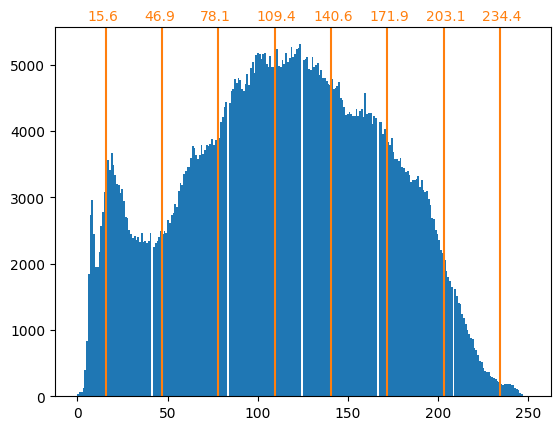

In [12]:
_, ax = plt.subplots()
ax.hist(raccoon_face.ravel(), bins=256)
color = "tab:orange"
for center in bin_center:
    ax.axvline(center, color=color)
    ax.text(center - 10, ax.get_ybound()[1] + 100, f"{center:.1f}", color=color)

- 균일한 샘플링 전략은 최적이 아니다.
    - 값 7에 매핑된 픽셀은 다소 적은 양의 정보를 인코딩한다.
    - 값 3에 매핑된 픽셀은 많은 양의 카운트를 나타낸다.
- k-means와 같은 클러스터링 전략을 사용하여 최적의 매핑을 찾을 수 있다.

c:\Users\Cal-01\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


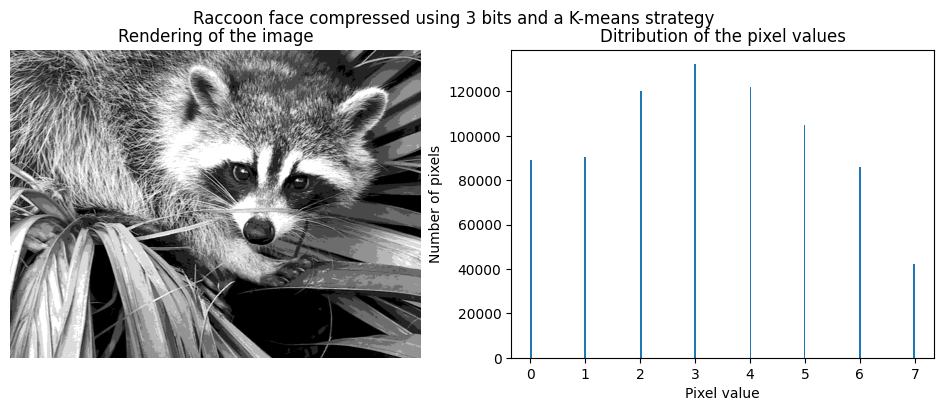

In [13]:
encoder = KBinsDiscretizer(
    n_bins=n_bins, encode='ordinal', strategy='kmeans', random_state=0
)
compressed_raccoon_kmeans = encoder.fit_transform(raccoon_face.reshape(-1, 1)).reshape(
    raccoon_face.shape
)

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

ax[0].imshow(compressed_raccoon_kmeans, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Rendering of the image')
ax[1].hist(compressed_raccoon_kmeans.ravel(), bins=256) 
ax[1].set_xlabel('Pixel value')
ax[1].set_ylabel('Number of pixels')
ax[1].set_title('Ditribution of the pixel values')
_ = fig.suptitle('Raccoon face compressed using 3 bits and a K-means strategy')

In [14]:
bin_edges = encoder.bin_edges_[0]
bin_center = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1]) / 2
bin_center

array([ 18.9141241 ,  53.3627656 ,  82.65000752, 109.26055499,
       134.68738405, 159.79431128, 185.18557327, 224.01945707])

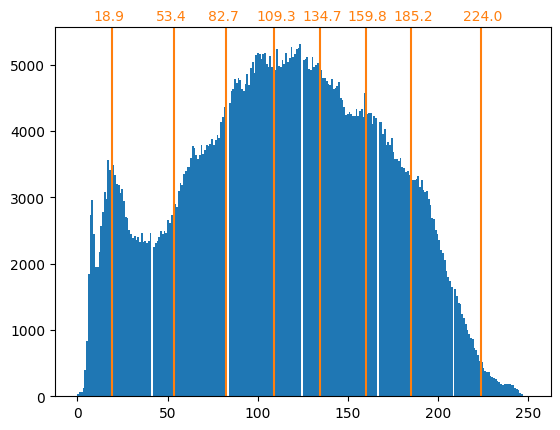

In [15]:
_, ax = plt.subplots()
ax.hist(raccoon_face.ravel(), bins=256)
color = "tab:orange"
for center in bin_center:
    ax.axvline(center, color=color)
    ax.text(center - 10, ax.get_ybound()[1] + 100, f"{center:.1f}", color=color)

- 이제 숫자들은 균형을 이루게 된다.
- 중심은 더 이상 같은 간격이 아니다.
- `strategy='kmeans'` 대신 `strategy='qunantile'`을 사용하면 같은 수의 픽셀을 적용할 수 있다.

### Memory footprint


In [16]:
print(f"The number of bytes taken in RAM is {compressed_raccoon_kmeans.nbytes}")
print(f"Compression ratio: {compressed_raccoon_kmeans.nbytes / raccoon_face.nbytes}")

The number of bytes taken in RAM is 6291456
Compression ratio: 8.0


- 압축된 이미지가 원래 이미지보다 X8 더 많은 메모리를 가지고 있다.
이미지를 인코딩하는 데 사용된 데이터 유형 때문이다.

In [17]:
print(f"Type of the compressed image: {compressed_raccoon_kmeans.dtype}")

Type of the compressed image: float64
